# Transfer Learning And Fine-Tuning

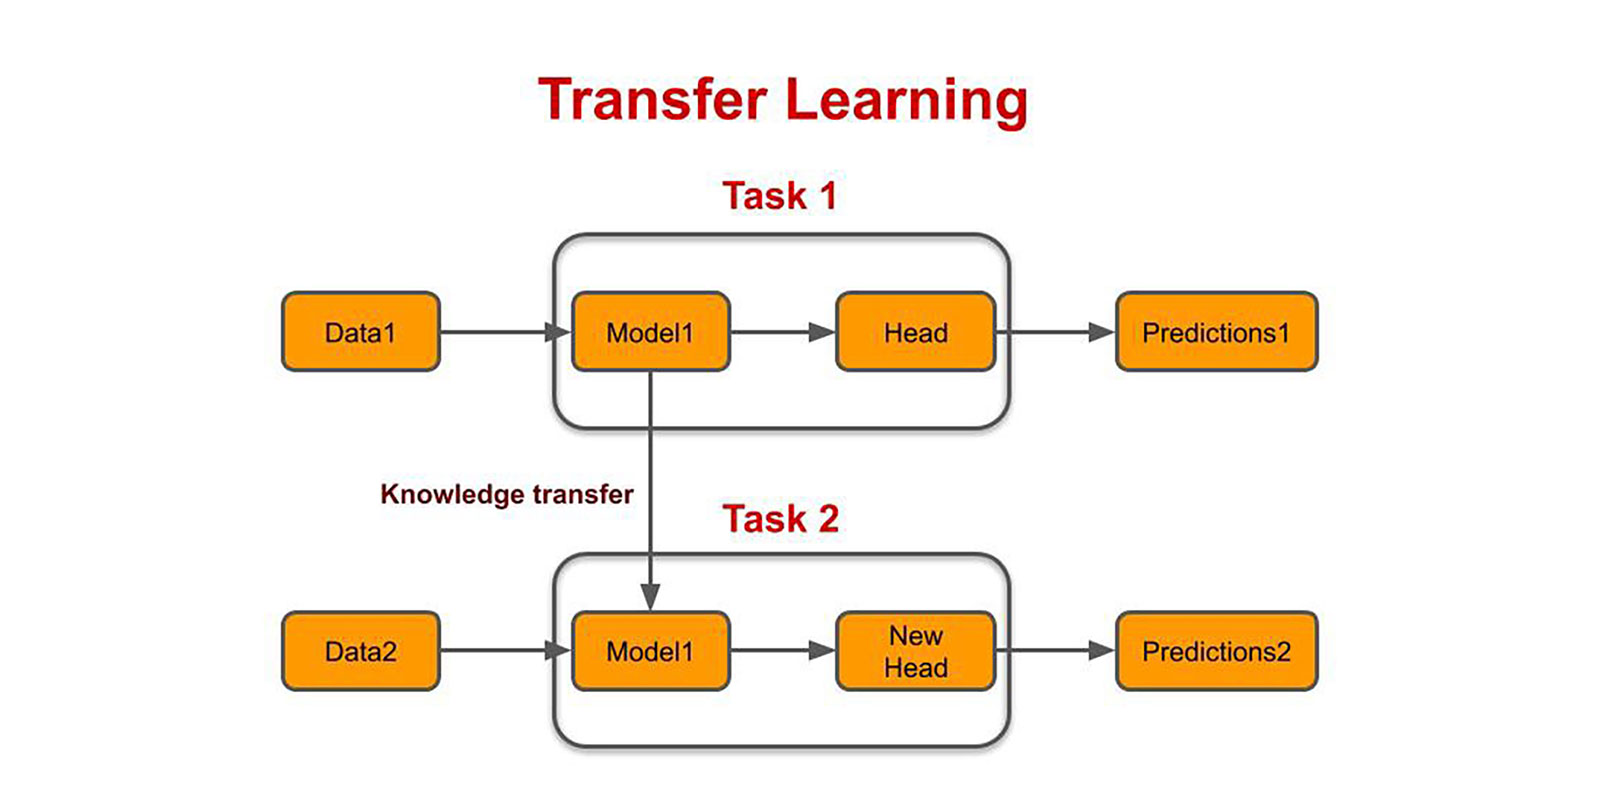

Reference: https://www.tensorflow.org/tutorials/images/transfer_learning

One of the famous methods in machine learning to train a model with a relatively small dataset is Transfer Learning. \
In this method we use a pre-trained model on a relative dataset and fine-tune for our dataset.

Keras has a good repository of computer vision models under `tf.keras.applications` [more info](https://keras.io/api/applications/) \
Also you can checkout [TensorFlow Hub](https://tfhub.dev/) for more models.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
from google.colab import output
output.enable_custom_widget_manager()

In [3]:
def preprocess_dataset(img, label):
    img = tf.divide(tf.cast(img, tf.float32), 255.)
    #encoded_label = tf.one_hot(label, depth=10)
    return img, label

In [4]:
ds, info = tfds.load("horses_or_humans", split=["train[:80%]", "train[80%:]", "test"], as_supervised=True, with_info=True)
ds_train = ds[0]
ds_val = ds[1]
ds_test = ds[2]
ds_train = ds_train.map(preprocess_dataset).shuffle(1000).batch(64)
ds_val = ds_val.map(preprocess_dataset).batch(64)
ds_test = ds_test.map(preprocess_dataset).batch(64)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1027 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/horses_or_humans/3.0.0.incompleteGLFBN6/horses_or_humans-train.tfrecord*...:  …

Generating test examples...:   0%|          | 0/256 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/horses_or_humans/3.0.0.incompleteGLFBN6/horses_or_humans-test.tfrecord*...:   …

Dataset horses_or_humans downloaded and prepared to ~/tensorflow_datasets/horses_or_humans/3.0.0. Subsequent calls will reuse this data.


## Create the base model from the pre-trained convnets
You will create the base model from the **MobileNet V2** model developed at Google. This is pre-trained on the **ImageNet** dataset, a large dataset consisting of 1.4M images and 1000 classes. ImageNet is a research training dataset with a wide variety of categories like jackfruit and syringe. This base of knowledge will help us classify cats and dogs from our specific dataset.

First, you need to pick which layer of MobileNet V2 you will use for feature extraction. The very last classification layer (on "top", as most diagrams of machine learning models go from bottom to top) is not very useful. Instead, you will follow the common practice to depend on the very last layer before the flatten operation. This layer is called the "bottleneck layer". The bottleneck layer features retain more generality as compared to the final/top layer.

First, instantiate a MobileNet V2 model pre-loaded with weights trained on ImageNet. By specifying the **include_top=False** argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.

In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(300, 300, 3),
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [6]:
image_batch, label_batch = next(iter(ds_train))
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([64, 10, 10, 1280])

In [7]:
type(base_model)

keras.engine.functional.Functional

In [8]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                              

## Freeze the convolutional base
It is important to freeze the convolutional base before you compile and train the model. Freezing (by setting `layer.trainable = False`) prevents the weights in a given layer from being updated during training. MobileNet V2 has many layers, so setting the entire model's trainable flag to False will freeze all of them.

In [9]:
base_model.trainable = False

In [10]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                              

## Add a classification head

In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [12]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


## Creating the Model

In [13]:
inputs = tf.keras.Input(shape=(300, 300, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable

## Compile the model

In [15]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable

In [17]:
history = model.fit(ds_train,
                    epochs=10,
                    validation_data=ds_val)

Epoch 1/10
13/13 [==============================] - 11s 455ms/step - loss: 0.6033 - accuracy: 0.6934 - val_loss: 0.5643 - val_accuracy: 0.8439
Epoch 2/10
13/13 [==============================] - 3s 208ms/step - loss: 0.5453 - accuracy: 0.7835 - val_loss: 0.5077 - val_accuracy: 0.8927
Epoch 3/10
13/13 [==============================] - 3s 198ms/step - loss: 0.4951 - accuracy: 0.8394 - val_loss: 0.4619 - val_accuracy: 0.9415
Epoch 4/10
13/13 [==============================] - 3s 198ms/step - loss: 0.4511 - accuracy: 0.8577 - val_loss: 0.4189 - val_accuracy: 0.9610
Epoch 5/10
13/13 [==============================] - 3s 198ms/step - loss: 0.4112 - accuracy: 0.8929 - val_loss: 0.3848 - val_accuracy: 0.9707
Epoch 6/10
13/13 [==============================] - 3s 197ms/step - loss: 0.3803 - accuracy: 0.9088 - val_loss: 0.3532 - val_accuracy: 0.9805
Epoch 7/10
13/13 [==============================] - 3s 214ms/step - loss: 0.3446 - accuracy: 0.9453 - val_loss: 0.3244 - val_accuracy: 0.9805
Epoch

## Fine tuning
In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. The weights of the pre-trained network were **not** updated during training.

One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the pre-trained model alongside the training of the classifier you added. The training process will force the weights to be tuned from generic feature maps to features associated specifically with the dataset.

**Note**: This should only be attempted after you have trained the top-level classifier with the pre-trained model set to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) and your pre-trained model will forget what it has learned.
Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, rather than overwrite the generic learning.


### Un-freeze the top layers of the model
All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the model (necessary for these changes to take effect), and resume training.

In [18]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### Compile The Model

In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,862,721
Non-train

In [20]:
history_fine = model.fit(ds_train,
                         epochs=20,
                         initial_epoch=history.epoch[-1],
                         validation_data=ds_val)

Epoch 10/20
13/13 [==============================] - 11s 376ms/step - loss: 0.0833 - accuracy: 0.9951 - val_loss: 0.0230 - val_accuracy: 1.0000
Epoch 11/20
13/13 [==============================] - 4s 270ms/step - loss: 0.0151 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 12/20
13/13 [==============================] - 4s 272ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 13/20
13/13 [==============================] - 4s 271ms/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 14/20
13/13 [==============================] - 4s 272ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 15/20
13/13 [==============================] - 4s 271ms/step - loss: 7.2338e-04 - accuracy: 1.0000 - val_loss: 4.2677e-04 - val_accuracy: 1.0000
Epoch 16/20
13/13 [==============================] - 4s 271ms/step - loss: 4.4751e-04 - accuracy: 1.0000 - val_loss: 2.2122e-04 - val

In [21]:
model.evaluate(ds_test)

4/4 [==============================] - 1s 147ms/step - loss: 0.0013 - accuracy: 1.0000


[0.0013015147997066379, 1.0]